## Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import CNN, build_resnet
from gaf import GAF
from train import train_model
import os
from pathlib import Path
from utils import ECGDataset, plot_classifier_curves, plot_gaf_samples,plot_gaf_both, evaluate_classifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

torch.manual_seed(42)
os.makedirs('./logs/',exist_ok=True)
os.makedirs('./saved_models',exist_ok=True)

# Model 1: CNN - GASF
log_path_1 = Path('./logs/cnn_gasf.csv')
model_path_1 = Path('./saved_models/cnn_gasf.pt')

# Model 2: CNN - GADF
log_path_2 = Path('./logs/cnn_gadf.csv')
model_path_2 = Path('./saved_models/cnn_gadf.pt')

# Model 3: CNN - GASF + GADF
log_path_3 = Path('./logs/cnn_both.csv')
model_path_3 = Path('./saved_models/cnn_both.pt')

# Model 4: ResNet - GASF + GADF
log_path_4 = Path('./logs/resnet_both.csv')
model_path_4 = Path('./saved_models/resnet_both.pt')

# Parameters
BATCH_SIZE=32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = ['N','S','V','F','Q']

### Load Dataset

In [ ]:
# Load datasets
train_data = pd.read_csv('../data/ecg_signals/mitbih_train.csv', header=None)
test_data = pd.read_csv('../data/ecg_signals/mitbih_test.csv', header=None)

# Extract features and labels
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].astype(int).values

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state=42)

# Load test set
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].astype(int).values

C:\Users\harsh\AppData\Local\Temp\ipykernel_29336\663069994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")


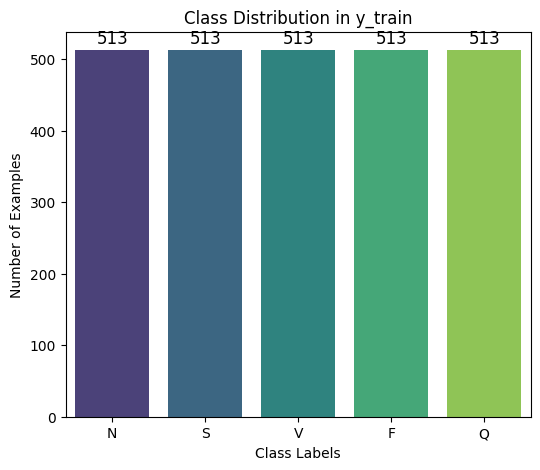

In [3]:
# Class label mapping
class_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Count occurrences of each class
unique_classes, counts = np.unique(y_train, return_counts=True)


# Plot class distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in y_train")

# Show values on bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()

## Exploratory Data Analysis

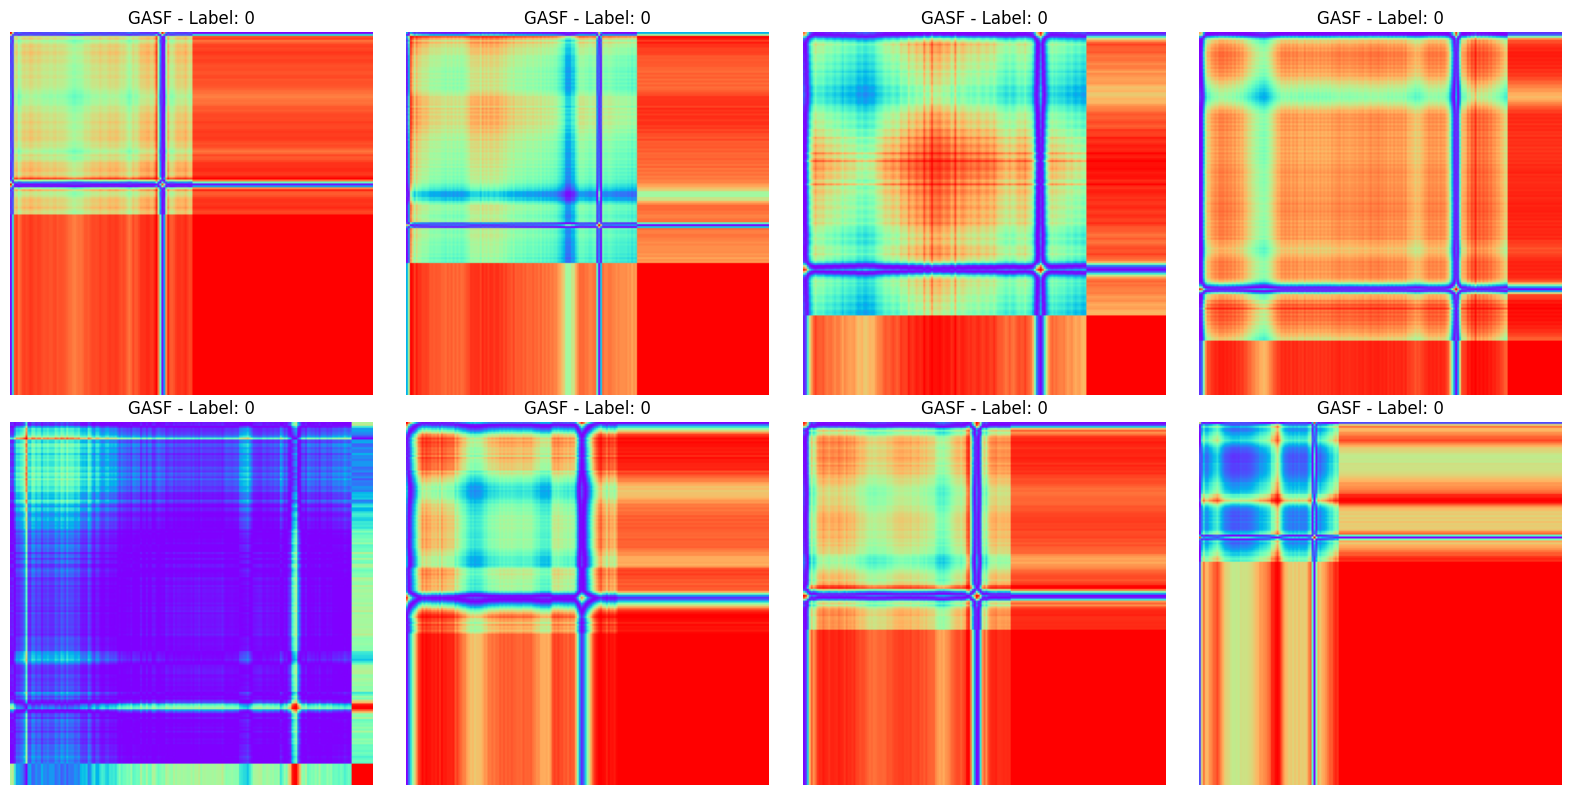

In [4]:
train_dataset_gasf = ECGDataset(X_train, y_train,gaf_mode='gasf')

plot_gaf_samples(dataset=train_dataset_gasf,num_samples=8,cols=4)


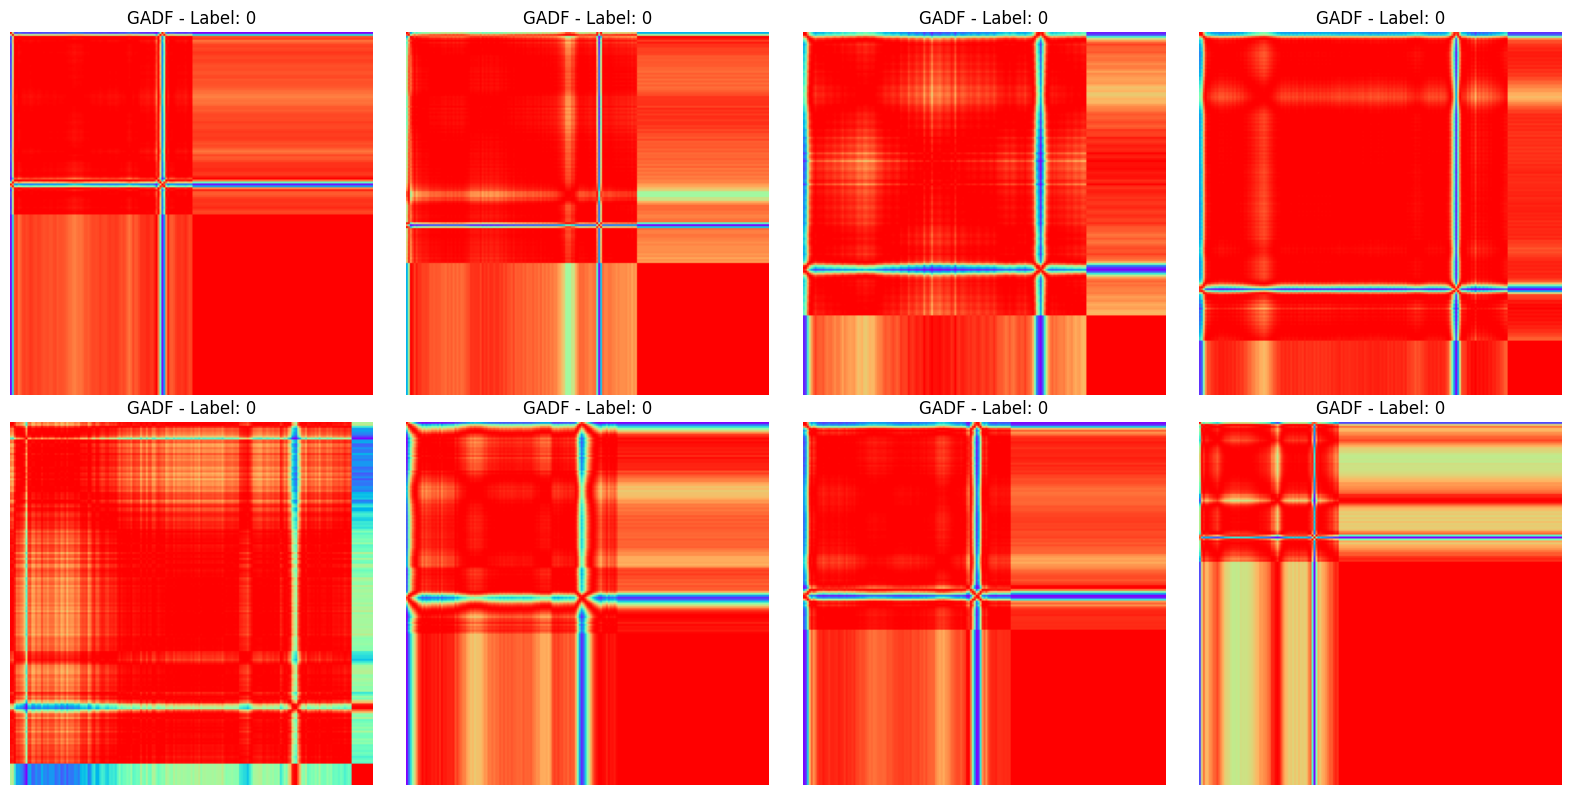

In [5]:
train_dataset_gadf = ECGDataset(signals=X_train,labels=y_train,gaf_mode='gadf')
plot_gaf_samples(dataset=train_dataset_gadf,num_samples=8,cols=4,gaf_type='GADF')

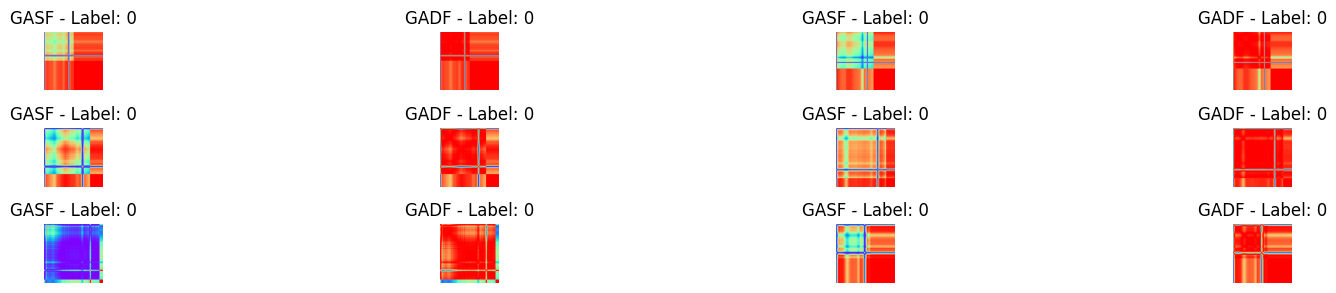

In [6]:
train_dataset_both = ECGDataset(signals=X_train,labels=y_train)
plot_gaf_both(dataset=train_dataset_both,num_samples=6,cols=4,gaf_type='GASF + GADF')

## Model 1 - CNN - GASF

In [7]:
# train_dataset = ECGDataset(signals=X_train,
#                            labels=y_train,
#                            gaf_mode='gasf')
# val_dataset = ECGDataset(signals=X_val,
#                          labels=y_val,
#                          gaf_mode='gasf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gasf')

# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True)
# val_loader = DataLoader(dataset=val_dataset,
#                         batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_1 = CNN()
# train_model(model=model_1,
#             train_loader=train_loader,
#             val_loader=val_loader,
#             device=device,
#             num_epochs=50,
#             log_path=log_path_1,
#             model_path=model_path_1,
#             patience=10)

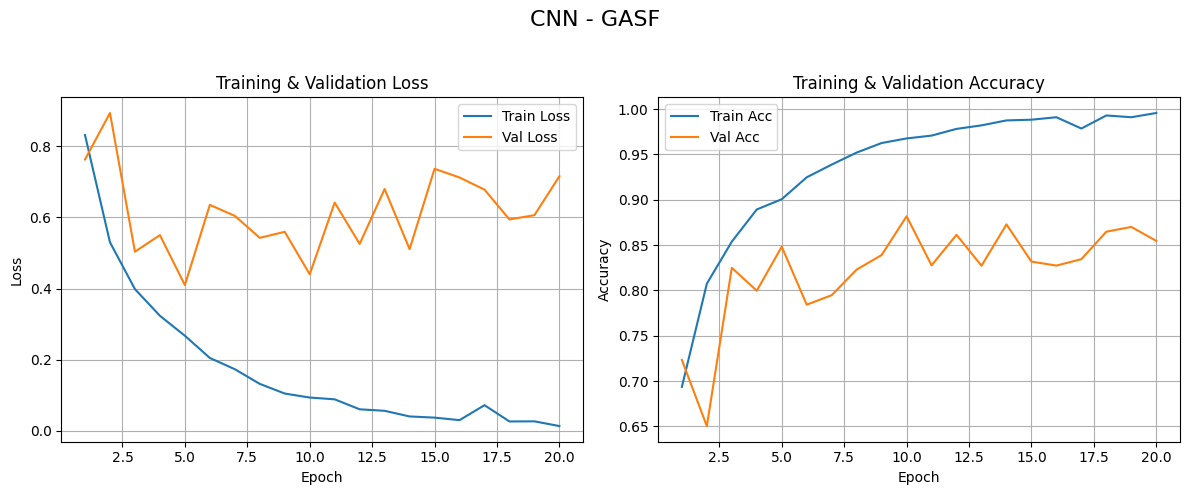

Accuracy: 0.0661
Classification Report:
               precision    recall  f1-score   support

           N       0.00      0.00      0.00     18118
           S       0.00      0.00      0.00       556
           V       0.07      1.00      0.12      1448
           F       0.00      0.00      0.00       162
           Q       0.00      0.00      0.00      1608

    accuracy                           0.07     21892
   macro avg       0.01      0.20      0.02     21892
weighted avg       0.00      0.07      0.01     21892



c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


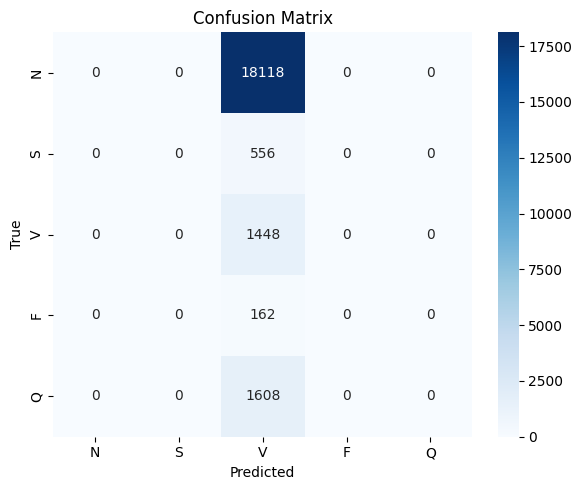

In [8]:
plot_classifier_curves(
    log_path=log_path_1,
    suptitle='CNN - GASF'
)

evaluate_classifier(
    model=model_1,
    dataloader=test_loader_1,
    class_names=class_names,
    device=device
)

## Model 2: CNN - GADF

In [9]:
# train_dataset = ECGDataset(signals=X_train,
#                            labels=y_train,
#                            gaf_mode='gadf')
# val_dataset = ECGDataset(signals=X_val,
#                          labels=y_val,
#                          gaf_mode='gadf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gadf')

# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True)
# val_loader = DataLoader(dataset=val_dataset,
#                         batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_2 = CNN()
# train_model(model=model_2,
#             train_loader=train_loader,
#             val_loader=val_loader,
#             device=device,
#             num_epochs=50,
#             log_path=log_path_2,
#             model_path=model_path_2,
#             patience=10)

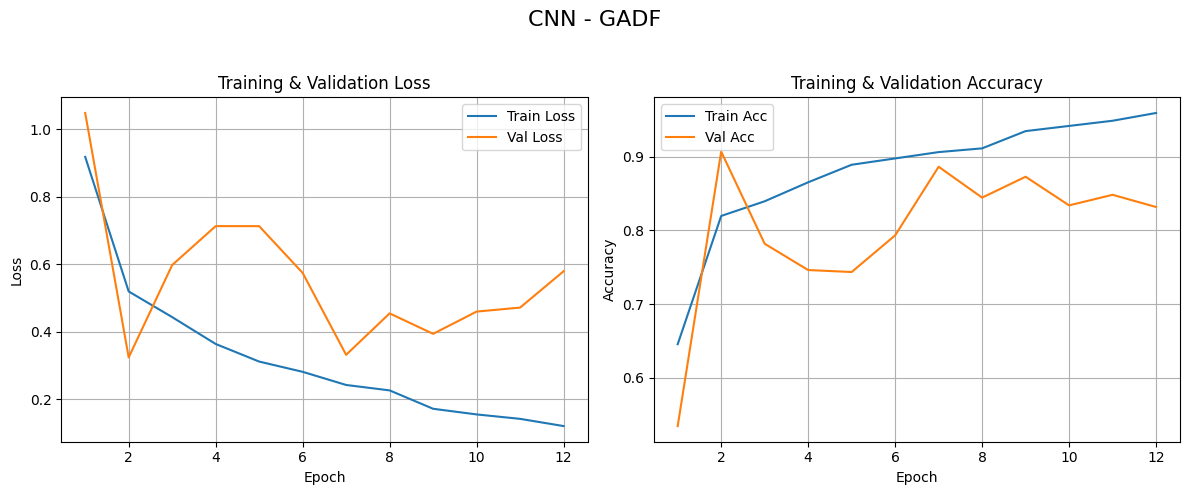

Accuracy: 0.0661
Classification Report:
               precision    recall  f1-score   support

           N       0.00      0.00      0.00     18118
           S       0.00      0.00      0.00       556
           V       0.07      1.00      0.13      1448
           F       0.00      0.00      0.00       162
           Q       0.00      0.00      0.00      1608

    accuracy                           0.07     21892
   macro avg       0.01      0.20      0.03     21892
weighted avg       0.00      0.07      0.01     21892



c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


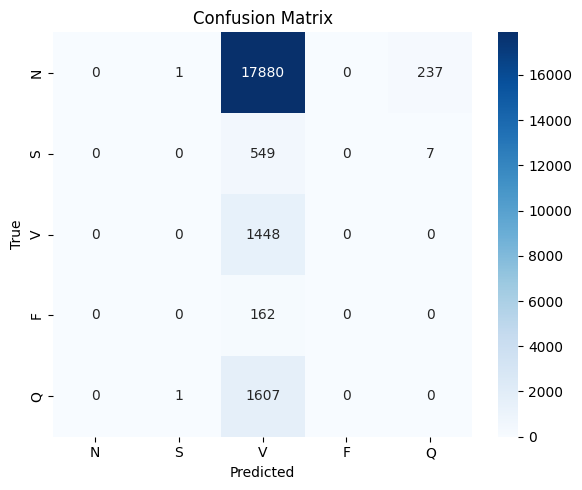

In [10]:
plot_classifier_curves(log_path=log_path_2,suptitle='CNN - GADF')

evaluate_classifier(
    model=model_2,
    dataloader=test_loader_2,
    class_names=class_names,
    device=device
)

## Model 3: CNN - both

In [11]:
# train_dataset = ECGDataset(signals=X_train,
#                            labels=y_train,
#                            gaf_mode='both')
# val_dataset = ECGDataset(signals=X_val,
#                          labels=y_val,
#                          gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True)
# val_loader = DataLoader(dataset=val_dataset,
#                         batch_size=BATCH_SIZE)
test_loader_3 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


# model_3 = CNN(in_channels=2)
# train_model(model=model_3,
#             train_loader=train_loader,
#             val_loader=val_loader,
#             device=device,
#             num_epochs=50,
#             log_path=log_path_3,
#             model_path=model_path_3,
#             patience=10)

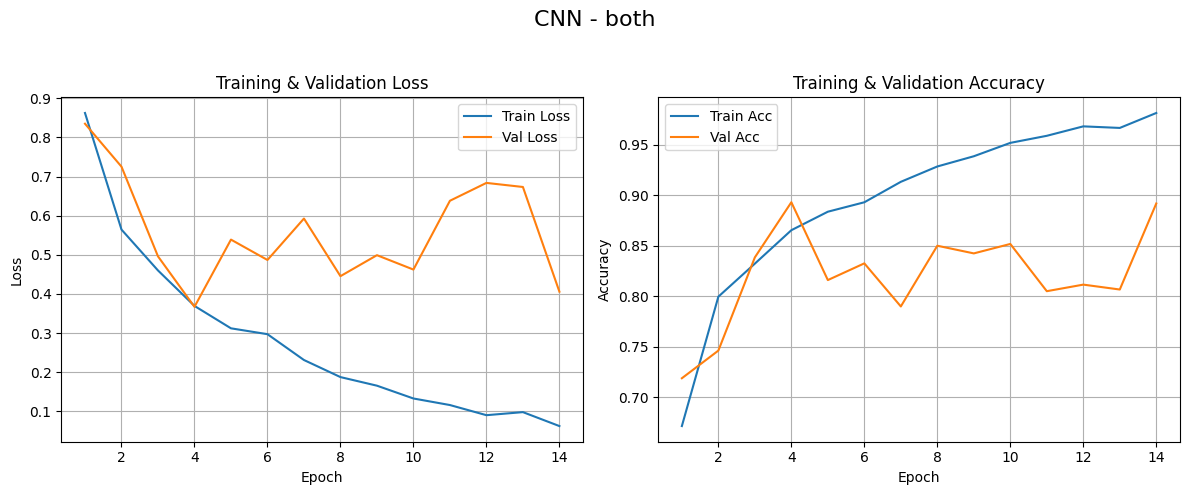

In [12]:
plot_classifier_curves(
    log_path=log_path_3,
    suptitle='CNN - both'
)

## Model 4: ResNet - both

In [13]:
# train_dataset = ECGDataset(signals=X_train,
#                            labels=y_train,
#                            gaf_mode='both')
# val_dataset = ECGDataset(signals=X_val,
#                          labels=y_val,
#                          gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True)
# val_loader = DataLoader(dataset=val_dataset,
#                         batch_size=BATCH_SIZE)
test_loader_4 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_4 = build_resnet(in_channels=2)
# train_model(model=model_4,
#             train_loader=train_loader,
#             val_loader=val_loader,
#             device=device,
#             num_epochs=50,
#             log_path=log_path_4,
#             model_path=model_path_4,
#             patience=10)

c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


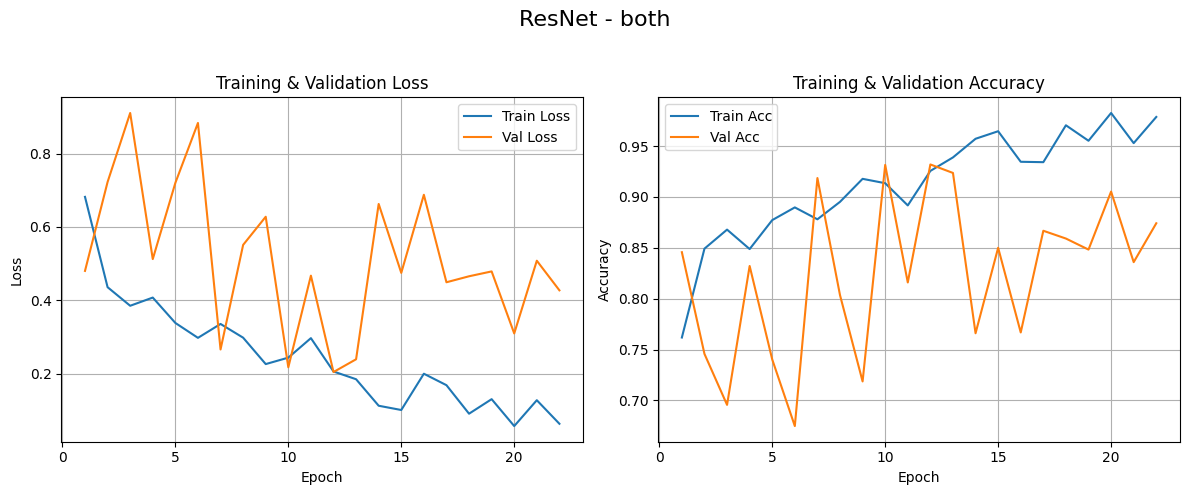

Accuracy: 0.0986
Classification Report:
               precision    recall  f1-score   support

           N       0.59      0.10      0.16     18118
           S       0.02      0.72      0.04       556
           V       0.08      0.02      0.04      1448
           F       0.00      0.00      0.00       162
           Q       0.00      0.00      0.00      1608

    accuracy                           0.10     21892
   macro avg       0.14      0.17      0.05     21892
weighted avg       0.49      0.10      0.14     21892



c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projects\python\algorithms\mainenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


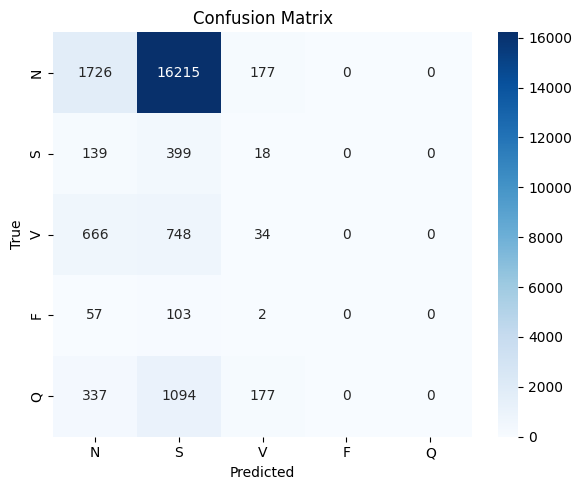

In [14]:
plot_classifier_curves(
    log_path=log_path_4,
    suptitle='ResNet - both'
)

evaluate_classifier(
    model=model_4,
    dataloader=test_loader_4,
    class_names=class_names,
    device=device
)